In [4]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
min_datetime = datetime.datetime(2020, 3, 1)
max_datetime = datetime.datetime(2020, 11, 15)
dates = helper.list_datetimes_in_range(min_datetime, max_datetime)
print('Num dates', len(dates))
s = datetime.datetime(2020, 11, 1, 0)  # start date

Num dates 260


In [5]:
# load county-level ACS and NYT data
acs_5yr = pd.read_csv(PATH_TO_ACS_5YR_DATA)
acs_5yr['id_to_match_to_safegraph_data'] = acs_5yr['GEOID'].map(lambda x:x.split("US")[1]).astype(int)
acs_5yr['fips'] = get_fips_codes_from_state_and_county_fp(acs_5yr.STATEFP, acs_5yr.COUNTYFP)
acs_counties = acs_5yr.fips.unique()
acs_data = helper.load_and_reconcile_multiple_acs_data()
cbgs_to_census_pops = dict(zip(acs_data['census_block_group'].values,
                            acs_data['total_cbg_population_2018_1YR'].values))  # use most recent population data
county2cbgs = {}
for county in acs_counties:
    county_cbgs = acs_5yr[acs_5yr.fips == county]['id_to_match_to_safegraph_data'].values
    pop_sizes = [cbgs_to_census_pops[c] for c in county_cbgs]
    county2cbgs[county] = (county_cbgs, pop_sizes)

nyt_outcomes = get_nyt_outcomes_over_counties()
nyt_counties = nyt_outcomes.fips.unique()
overlap_counties = set(acs_counties).intersection(set(nyt_counties))
print('Found %d counties in ACS 5-year; %d counties in NYT -> %d overlap' % 
      (len(acs_counties), len(nyt_counties), len(overlap_counties)))
nyt_outcomes.head()

220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
Found 3142 counties in ACS 5-year; 3219 counties in NYT -> 3135 overlap


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


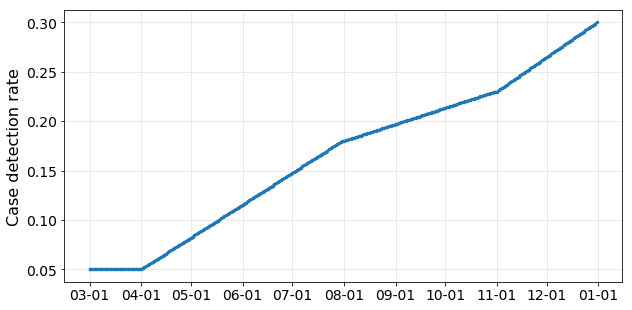

In [6]:
all_dates, all_rates = helper.get_daily_case_detection_rate()  # based on IHME estimate
fig, ax = plt.subplots(figsize=(10,5))
ax.plot_date(all_dates, all_rates, marker='.', markersize=5, linestyle='-')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_ylabel('Case detection rate', fontsize=16)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
plt.show()

In [17]:
def get_seir_at_given_time(s, county, nyt_outcomes, county2cbgs, dates, rate_over_time, mode='cases', verbose=True):
    assert mode in {'cases', 'deaths'}
    county_df = nyt_outcomes[nyt_outcomes.fips == county]
    county_name = county_df.iloc[0]['county']
    state = county_df.iloc[0]['state']
    cbgs, pop_sizes = county2cbgs[county]
    if mode == 'deaths':
        lag = datetime.timedelta(days=DEATH_LAG)
    else:
        lag = datetime.timedelta(days=DETECTION_LAG)
    reported_dates = helper.list_datetimes_in_range(dates[0]+lag, dates[-1]+lag)
    hours = helper.list_hours_in_range(dates[0], dates[-1]+datetime.timedelta(hours=23))
    assert len(hours) == (len(dates) * 24)
    assert s in hours
    
    # get cumulative and daily counts for county
    cumulative_counts = []
    first_date = np.min(county_df.date)
    for date in reported_dates:
        date_str = date.strftime('%Y-%m-%d')
        sub_df = county_df[county_df.date == date_str]
        if date_str < first_date:  # no data yet, assume count is 0
            cumulative_counts.append(0)
        elif len(sub_df) > 0:
            assert len(sub_df) == 1
            cumulative_counts.append(sub_df.iloc[0][mode])
        else:
            cumulative_counts.append(np.nan)
    cumulative_counts = np.array(cumulative_counts)
    num_nans = np.sum(np.isnan(cumulative_counts))
    if num_nans > 0:  # this will print if there is a break in data
        print('%s, %s: missing %s data for %d dates' % (county_name, state, mode, num_nans))
    daily_counts = get_daily_from_cumulative(np.array(cumulative_counts))
    # using np.nanmean will get rid of nans, unless the entire 2-week period is nan
    smoothed_daily_counts = apply_smoothing(daily_counts, before=7, after=7, agg_func=np.nanmean)  # apply 2-week smoothing
    if verbose:
        fig, ax = plt.subplots(figsize=(7,5))
        ax.plot_date(reported_dates, daily_counts, marker='x', color='grey')
        ax.plot_date(reported_dates, smoothed_daily_counts, marker='.', linestyle='-', color='orange')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylabel('Daily %s' % mode)
        ax.set_title(county_name)
        plt.show()
        
    assert len(smoothed_daily_counts) == len(rate_over_time)
    daily_E_to_I = smoothed_daily_counts / rate_over_time   # scale by time-varying rate
    if verbose:
        fig, ax = plt.subplots(figsize=(7,5))
        ax.plot_date(dates, daily_E_to_I, marker='.', linestyle='-', color='blue')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=4))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylabel('Daily E->I')
        ax.set_title(county_name)
        plt.show()
    
    hourly_E_to_I = np.zeros(len(hours))  # convert daily to hourly
    for t in range(len(hourly_E_to_I)):
        d = int(t/24)
        hourly_E_to_I[t] = daily_E_to_I[d] / 24  # assume 1/24 of daily count happened in each hour
    s_index = hours.index(s)
    latency_period = int(LATENCY_PERIOD_IN_DAYS * 24)  # in hours
    infectious_period = int(INFECTIOUS_PERIOD_IN_DAYS * 24)
    E = hourly_E_to_I * latency_period  # MLE
    E_s = E[s_index]
    I_s = E[s_index - latency_period]  # assume I is same as E but translated by latency_period
    # at time s, everything that entered I before s - infectious_period will have made it to R
    R_s = np.sum(hourly_E_to_I[:s_index - infectious_period])
    total_pop = np.sum(pop_sizes)
    S_s = total_pop - E_s - I_s - R_s
    if verbose:
        print('State of %s, %s on %s: S = %.1f%%; E = %.1f%%; I = %.1f%%; R = %.1f%%' % 
          (county_name, state, s.strftime('%Y-%m-%d'), 
           100. * S_s / total_pop, 100 * E_s / total_pop, 100. * I_s / total_pop, 100. * R_s / total_pop))
    return S_s, E_s, I_s, R_s

In [19]:
# SEIR estimates based on cases
_, cdr_over_time = helper.get_daily_case_detection_rate(min_datetime=min_datetime, max_datetime=max_datetime)
cases_county2seir = {}
for i, county in enumerate(sorted(overlap_counties)):  # sort by fips - will naturally sort by state
    cases_county2seir[county] = get_seir_at_given_time(s, county, nyt_outcomes, county2cbgs, dates, 
                                                       cdr_over_time, mode='cases', verbose=False)
    if i % 100 == 99:
        print('CHECKPOINT: finished processing %d counties!' % (i+1))

CHECKPOINT: finished processing 100 counties!
CHECKPOINT: finished processing 200 counties!
CHECKPOINT: finished processing 300 counties!
CHECKPOINT: finished processing 400 counties!
CHECKPOINT: finished processing 500 counties!
Clark, Idaho: missing cases data for 6 dates
Lewis, Idaho: missing cases data for 34 dates
CHECKPOINT: finished processing 600 counties!
CHECKPOINT: finished processing 700 counties!
CHECKPOINT: finished processing 800 counties!
CHECKPOINT: finished processing 900 counties!
CHECKPOINT: finished processing 1000 counties!
CHECKPOINT: finished processing 1100 counties!
CHECKPOINT: finished processing 1200 counties!
CHECKPOINT: finished processing 1300 counties!
CHECKPOINT: finished processing 1400 counties!
CHECKPOINT: finished processing 1500 counties!
CHECKPOINT: finished processing 1600 counties!
Dundy, Nebraska: missing cases data for 4 dates
CHECKPOINT: finished processing 1700 counties!
Keya Paha, Nebraska: missing cases data for 7 dates
Sioux, Nebraska: mi

In [21]:
# convert county-level to CBG-level
mode = 'cases'
county2seir = cases_county2seir
rows = []
for i, county in enumerate(sorted(overlap_counties)):
    county_name = nyt_outcomes[nyt_outcomes.fips == county].iloc[0]['county']
    county_state = nyt_outcomes[nyt_outcomes.fips == county].iloc[0]['state']
    cbgs, popsizes = county2cbgs[county]
    total_pop = np.sum(popsizes)  # county pop size
    if i % 100 == 99:
        print('CHECKPOINT: finished processing %d counties!' % (i+1))
    seir = county2seir[county]
    if np.sum(np.isnan(seir)) > 0:
        print('Skipping %s, %s (%d CBGs) bc of nan SEIR' % (county_name, county_state, len(cbgs)))
    else:
        for cbg, cbg_pop in zip(cbgs, popsizes):
            row = {'census_block_group':cbg, 'county_fips':county, 'county_name':county_name, 'state':county_state}
            curr_sum = 0
            for i, state in enumerate(['E', 'I', 'R']):
                prop_in_state = seir[i+1] / total_pop  # assume CBGs within county have the same proportions
                num_in_state = int(round(cbg_pop * prop_in_state, 0))
                row['%s_%s' % (mode, state)] = num_in_state
                curr_sum += num_in_state
            row['%s_S' % mode] = cbg_pop - curr_sum  # do this to make sure it sums to population size; otherwise,
                                                     # rounding might throw things off
        assert len(row) == 8
        rows.append(row)
print('Processed %d CBGs' % len(rows))

CHECKPOINT: finished processing 100 counties!
CHECKPOINT: finished processing 200 counties!
CHECKPOINT: finished processing 300 counties!
CHECKPOINT: finished processing 400 counties!
CHECKPOINT: finished processing 500 counties!
Skipping Lewis, Idaho (6 CBGs) bc of nan SEIR
CHECKPOINT: finished processing 600 counties!
CHECKPOINT: finished processing 700 counties!
CHECKPOINT: finished processing 800 counties!
CHECKPOINT: finished processing 900 counties!
CHECKPOINT: finished processing 1000 counties!
CHECKPOINT: finished processing 1100 counties!
CHECKPOINT: finished processing 1200 counties!
CHECKPOINT: finished processing 1300 counties!
CHECKPOINT: finished processing 1400 counties!
CHECKPOINT: finished processing 1500 counties!
CHECKPOINT: finished processing 1600 counties!
CHECKPOINT: finished processing 1700 counties!
CHECKPOINT: finished processing 1800 counties!
CHECKPOINT: finished processing 1900 counties!
CHECKPOINT: finished processing 2000 counties!
CHECKPOINT: finished pr

In [23]:
cols = ['census_block_group', 'county_fips', 'county_name', 'state',
        'cases_S', 'cases_E', 'cases_I', 'cases_R']
df = pd.DataFrame(rows)[cols]
fn = os.path.join(PATH_TO_SEIR_INIT, 'all_cbgs_s=%s.csv' % (s.strftime('%Y-%m-%d')))
print(fn)
df.to_csv(fn, index=False)

/dfs/scratch2/second_safegraph_homes/all_aggregate_data/seir_init/all_cbgs_s=2020-11-01.csv
